## Intro and Preprocessing:
---

In [1]:
import cv2 
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
TRAIN_DIR = '/Users/harish3110/Desktop/cats-vs-dogs/train' # local path to training and testing data as dowloaded from kaggle
TEST_DIR =  '/Users/harish3110/Desktop/cats-vs-dogs/test'
IMG_SIZE = 50 #to maintain a constant size we'll resize all images to 50*50
LR = 1e-3  #learning rate is 0.001

In [3]:
MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '6conv-basic-video')

In [4]:
def label_img(img):
    word_label = img.split('.')[-3]
    
    if word_label == 'cat':
        return [1,0] #indicates that pic contains cats
    elif word_label == 'dog':
        return [0,1] #indicates that pic contains dog

In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img) #to obtain img label/name
        path = os.path.join(TRAIN_DIR, img) #to get complte path including pic name
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #read the img using cv2 in grayscale format
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) #resize image based on constant set before
        training_data.append([np.array(img), np.array(label)])
        #appending to list created before aswell as converting img read and label to numpy array format just in case
        
    shuffle(training_data) #self-explanatory
    np.save('train_data.npy', training_data) #for future use instead of running this function again; eg: if IMG_SIZE changed
    return training_data

In [6]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # can be done in one step
        testing_data.append([np.array(img), img_num])
    
    np.save('test_data.npy', testing_data)
    return testing_data

In [7]:
#train_data = create_train_data()
# else if you already have train data:
train_data = np.load('train_data.npy')

## Building the Network:
---

In [8]:
# importing convnet structure from https://pythonprogramming.net/tflearn-machine-learning-tutorial/

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')


## Training the Network:
---

In [9]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print("Model Loaded!")

INFO:tensorflow:Restoring parameters from /Users/harish3110/Desktop/cats-vs-dogs/dogsvscats-0.001-6conv-basic-video.model
Model Loaded!


In [10]:
train = train_data[:-500] 
test = train_data[-500:]

In [11]:
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [12]:
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 3829  | total loss: 0.35955 | time: 89.276s
| Adam | epoch: 005 | loss: 0.35955 - acc: 0.8422 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.34370 | time: 90.599s
| Adam | epoch: 005 | loss: 0.34370 - acc: 0.8455 | val_loss: 0.42998 - val_acc: 0.8180 -- iter: 24500/24500
--


In [13]:
model.save(MODEL_NAME)

INFO:tensorflow:/Users/harish3110/Desktop/cats-vs-dogs/dogsvscats-0.001-6conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


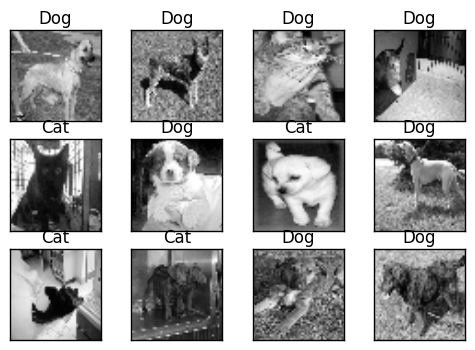

In [34]:
import matplotlib.pyplot as plt

# if you don't have this file yet the,
#test_data = process_test_data()

# if you already have it
test_data = np.load('test_data.npy')

fig = plt.figure()

# iterating through 1st 12 testing data and predict its classification

for num, data in enumerate(test_data[36:48]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
    
    y.imshow(orig, cmap ='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()